<a href="https://colab.research.google.com/github/capofwesh20/Masters-Thesis/blob/main/Copy_of_Training_notebook_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Relevant libraries and functions
from __future__ import print_function
import random
import matplotlib.pyplot as plt
import scipy.ndimage
import numpy as np, h5py
import os, time, sys
import tensorflow as tf
import keras
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, Input, SpatialDropout2D, UpSampling2D, MaxPooling2D, concatenate, SeparableConv2D, Conv2DTranspose
from tensorflow.keras.layers import Activation, Layer
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Input, add, Conv3D, Reshape
from tensorflow.keras.callbacks import History, EarlyStopping, ModelCheckpoint, CSVLogger
from itertools import cycle
from sklearn import metrics
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.utils as utils
import ipywidgets as widgets
from IPython.display import display
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
import tifffile as tiff
from keras.models import load_model
from skimage.metrics import structural_similarity as compare_ssim

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [ ]:
from tensorflow.keras.losses import MeanSquaredError

In [ ]:
f_data = '/content/drive/MyDrive/finish' # Directory with training data
stacks = os.listdir(f_data)
numS = len(stacks)
numS

500

# **SETTING UP THE IMAGES FOR TRAINING**

In [ ]:


# Directory containing training data
p_data = f_data  # Ensure f_data is defined with the correct path
stacks = os.listdir(p_data)
numS = len(stacks)

nTG = 256  # Number of time-points
xX = 32
yY = 32

# Initialize arrays to store data
tpsfD = np.zeros((numS, nTG, xX, yY, 1), dtype=np.float32)
t1 = np.zeros((numS, xX, yY, 1), dtype=np.float32)
t2 = np.zeros((numS, xX, yY, 1), dtype=np.float32)
a1 = np.zeros((numS, xX, yY, 1), dtype=np.float32)
a2 = np.zeros((numS, xX, yY, 1), dtype=np.float32)
offset = np.zeros((numS, xX, yY, 1), dtype=np.float32)

# Load data
for i, d in enumerate(stacks):
    # Load NPZ file
    data = np.load(os.path.join(p_data, d))

    # Transpose the data to match the expected shape and save values to respective arrays
    tpsfD[i, :, :, :, 0] = np.transpose(data['sigD'], (2, 0, 1))
    t1[i, :, :, 0] = data['t1']
    t2[i, :, :, 0] = data['t2']
    a1[i, :, :, 0] = data['a1']
    a2[i, :, :, 0] = data['a2']
    offset[i, :, :, 0] = data['offset']

# Adjust the axis if needed
tpsfD = np.moveaxis(tpsfD, 1, -2)


In [ ]:
# Ensure TPSF voxel shape is correct dimensionality (# samples, x, y, time-points, 1)
tpsfD.shape

(500, 32, 32, 256, 1)

In [ ]:
print(t1.shape, t2.shape, a1.shape)


(10000, 32, 32, 1) (10000, 32, 32, 1) (10000, 32, 32, 1)


# **UNDERSTANDING THE TRAINING DATA**

In [ ]:
# Relevant resblock functions (Keras API)
def resblock_2D(num_filters, size_filter, x):
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = Activation('relu')(Fx)
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    output = add([Fx, x])
    output = Activation('relu')(output)
    return output

def resblock_2D_BN(num_filters, size_filter, x):
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    #output = BatchNormalization()(output)
    output = Activation('relu')(output)
    return output

def resblock_3D_BN(num_filters, size_filter, x):
    Fx = Conv3D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = Conv3D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    #output = BatchNormalization()(output)
    output = Activation('relu')(output)
    return output

def xCeptionblock_2D_BN(num_filters, size_filter, x):
    Fx = SeparableConv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = SeparableConv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    output = Activation('relu')(output)
    return output

In [ ]:
modelD = None
xX = 32;
yY = 32;

t_data = Input(shape=(xX, yY, 256,1))
tpsf = t_data

# # # # # # # # 3D-Model # # # # # # # #

tpsf = Conv3D(50,kernel_size=(1,1,10),strides=(1,1,5), padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = resblock_3D_BN(50, (1,1,5), tpsf)
tpsf = Reshape((xX,yY,2600))(tpsf)
tpsf = Conv2D(256, 1, padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = Conv2D(256, 1, padding='same', activation=None, data_format="channels_last")(tpsf)
tpsf = BatchNormalization()(tpsf)
tpsf = Activation('relu')(tpsf)
tpsf = resblock_2D_BN(256, 1, tpsf)
tpsf = resblock_2D_BN(256, 1, tpsf)

# Short-lifetime branch
imgT1 = Conv2D(64, 1, padding='same', activation=None)(tpsf)
imgT1 = BatchNormalization()(imgT1)
imgT1 = Activation('relu')(imgT1)
imgT1 = Conv2D(32, 1, padding='same', activation=None)(imgT1)
imgT1 = BatchNormalization()(imgT1)
imgT1 = Activation('relu')(imgT1)
imgT1 = Conv2D(1, 1, padding='same', activation='relu', name='imgT1')(tpsf)

#Long-lifetime branch
imgT2 = Conv2D(64, 1, padding='same', activation=None)(tpsf)
imgT2 = BatchNormalization()(imgT2)
imgT2 = Activation('relu')(imgT2)
imgT2 = Conv2D(32, 1, padding='same', activation=None)(imgT2)
imgT2 = BatchNormalization()(imgT2)
imgT2 = Activation('relu')(imgT2)
imgT2 = Conv2D(1, 1, padding='same', activation='relu', name='imgT2')(tpsf)

# a1 branch
imga1 = Conv2D(64, 1, padding='same', activation=None)(tpsf)
imga1 = BatchNormalization()(imga1)
imga1 = Activation('relu')(imga1)
imga1 = Conv2D(32, 1, padding='same', activation=None)(imga1)
imga1 = BatchNormalization()(imga1)
imga1 = Activation('relu')(imga1)
imga1 = Conv2D(1, 1, padding='same', activation='relu', name='imga1')(tpsf)

# Amplitude-Ratio branch
imga2 = Conv2D(64, 1, padding='same', activation=None)(tpsf)
imga2 = BatchNormalization()(imga2)
imga2 = Activation('relu')(imga2)
imga2 = Conv2D(32, 1, padding='same', activation=None)(imga2)
imga2 = BatchNormalization()(imga2)
imga2 = Activation('relu')(imga2)
imga2 = Conv2D(1, 1, padding='same', activation='relu', name='imga2')(tpsf)


# Offset Branch (Final layer without activation)
imgA0 = Conv2D(64, 1, padding='same', activation=None)(tpsf)
imgA0 = BatchNormalization()(imgA0)
imgA0 = Activation('relu')(imgA0)
imgA0 = Conv2D(32, 1, padding='same', activation=None)(imgA0)
imgA0 = BatchNormalization()(imgA0)
imgA0 = Activation('relu')(imgA0)
imgA0 = Conv2D(1, 1, padding='same', activation='relu', name='imgA0')(tpsf)






In [ ]:
modelD = Model(inputs=[t_data], outputs=[imgT1, imgT2, imga1,imga2, imgA0])
rmsprop = RMSprop(learning_rate = 1e-5)

modelD.compile(loss='mse',
              optimizer=rmsprop,
              metrics=[['mae'], ['mae'], ['mae'], ['mae'], ['mae']])

In [ ]:
# # Input shape compatibility
print("Model input shape:", modelD.input_shape)


# # Output shape compatibility (for multiple outputs)
for i, output_shape in enumerate(modelD.output_shape):
    print(f"Model output shape {i+1}:", output_shape)



Model input shape: (None, 32, 32, 256, 1)
Model output shape 1: (None, 32, 32, 1)
Model output shape 2: (None, 32, 32, 1)
Model output shape 3: (None, 32, 32, 1)
Model output shape 4: (None, 32, 32, 1)
Model output shape 5: (None, 32, 32, 1)


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, lr):
    if epoch % 20 == 0 and epoch != 0:
        return lr * 0.8
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

In [ ]:
fN = 'epoch and weighting'  # Assign some name for weights and training/validation loss curves here

# Save loss curve (mse) and MAE information over all trained epochs. (monitor = '' can be changed to focus on other tau parameters)
modelCheckPoint = ModelCheckpoint(filepath=fN+'.keras',
                                  monitor='val_loss',
                                  save_best_only=True,
                                  verbose=0)

# Train network (80/20 train/validation split, batch_size=20 recommended, nb_epoch may vary based on application)
csv_logger = CSVLogger(fN+'.log')
history = modelD.fit([tpsfD], [t1, t2, a1, a2, offset],
                     validation_split=0.2,
                     batch_size=20, epochs=250, verbose=1, shuffle=True,
                     callbacks=[csv_logger, modelCheckPoint])


Epoch 1/250


AttributeError: 'NoneType' object has no attribute 'items'

Save to drive. This way, you can leave the training to run overnight

In [2]:
# Import required library
import shutil

# Define the source and destination paths
source_path = '/content/epoch and tuning.keras'
destination_path = '/content/drive/MyDrive/thesis models/epoch and tuning.keras'

# Move the file
shutil.move(source_path, destination_path)
print(f"File moved to {destination_path}")


File moved to /content/drive/MyDrive/thesis models/epoch and tuning.keras


In [ ]:
# model.summary()
# #

In [ ]:
print(history.history.keys())


dict_keys(['imgA0_loss', 'imgA0_mae', 'imgT1_loss', 'imgT1_mae', 'imgT2_loss', 'imgT2_mae', 'imga1_loss', 'imga1_mae', 'imga2_loss', 'imga2_mae', 'loss', 'val_imgA0_loss', 'val_imgA0_mae', 'val_imgT1_loss', 'val_imgT1_mae', 'val_imgT2_loss', 'val_imgT2_mae', 'val_imga1_loss', 'val_imga1_mae', 'val_imga2_loss', 'val_imga2_mae', 'val_loss'])


In [ ]:
def plot_metric(history, metric, val_metric, title, ylabel):
    epochs = range(1, len(history.history[metric]) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history.history[metric], 'b-', label=f'Training {metric}')
    plt.plot(epochs, history.history[val_metric], 'r-', label=f'Validation {val_metric}')
    plt.title(title, fontsize = 18)
    plt.xlabel('Epochs', fontsize = 18)
    plt.ylabel(ylabel, fontsize = 18)
    plt.legend()
    plt.show()


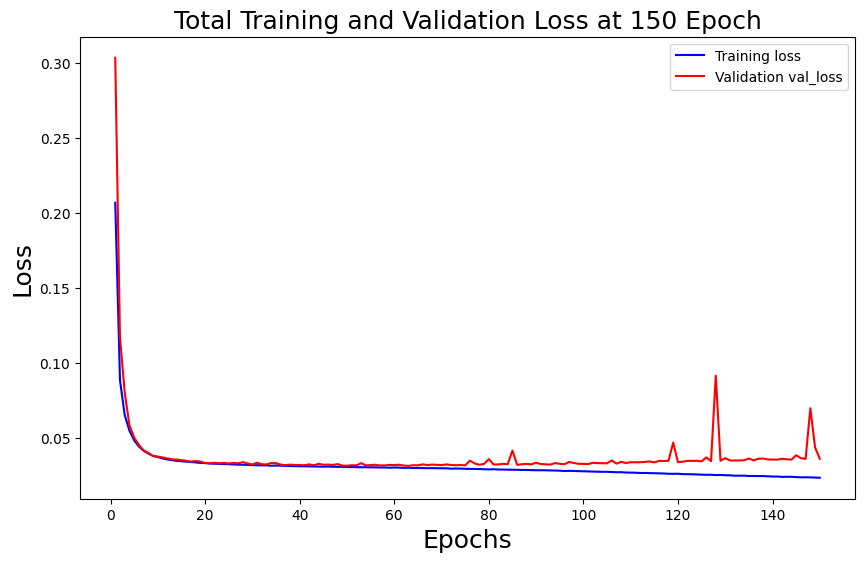

In [ ]:
plot_metric(history, 'loss', 'val_loss', 'Total Training and Validation Loss at 150 Epoch', 'Loss')


$\tau_1$, r'$\tau_2$', r'$A_1$', r'$A_2$'

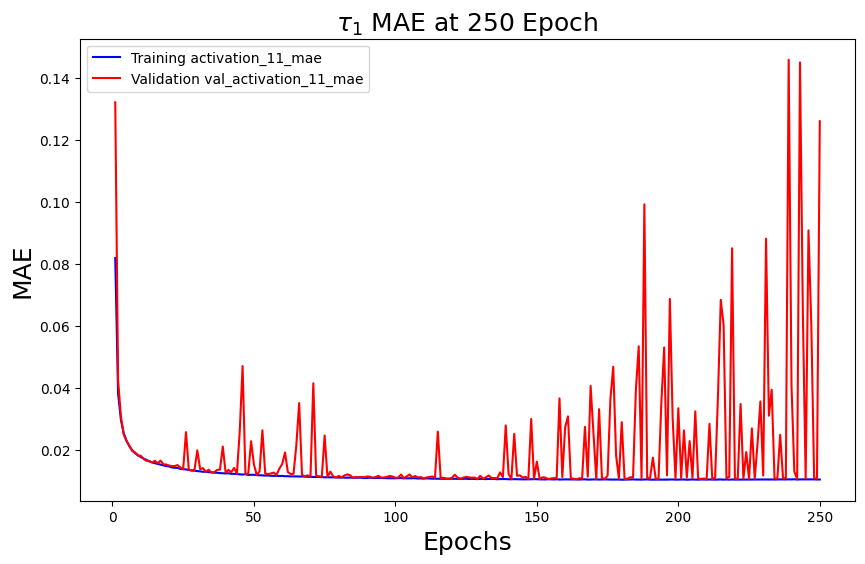

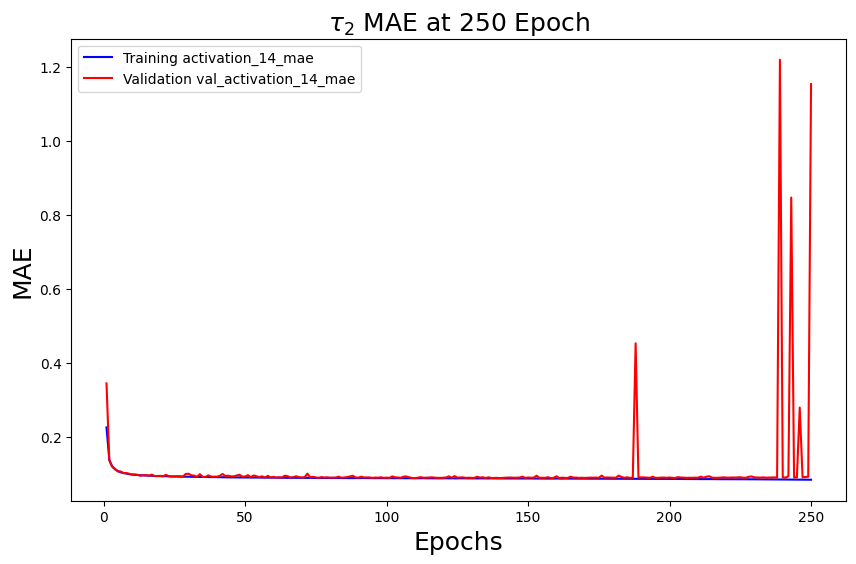

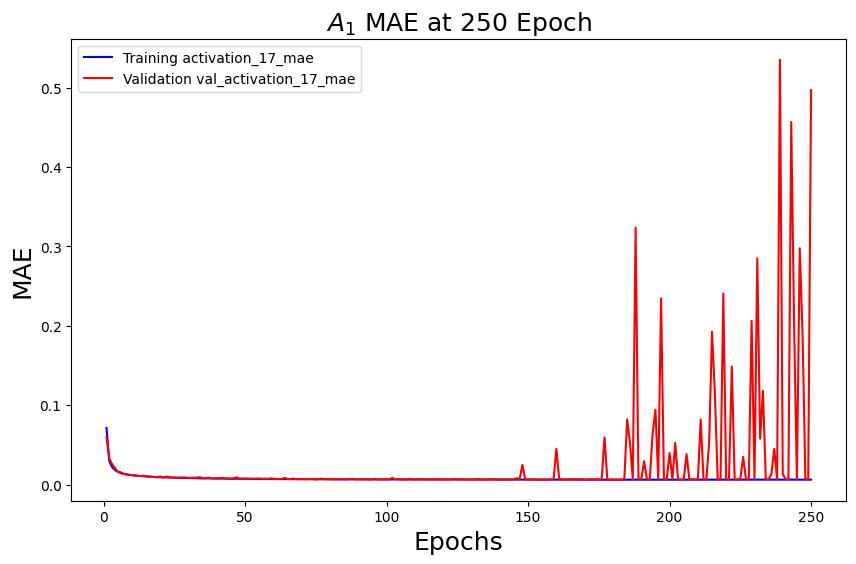

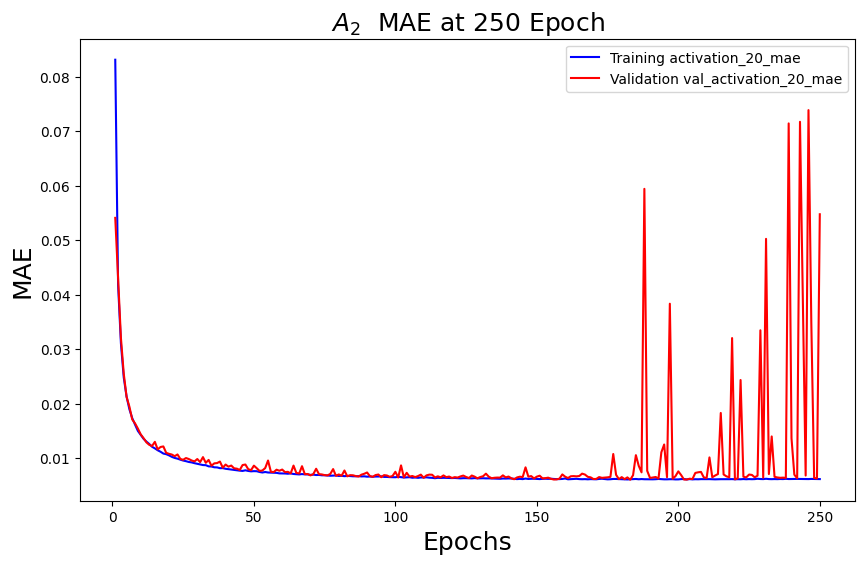

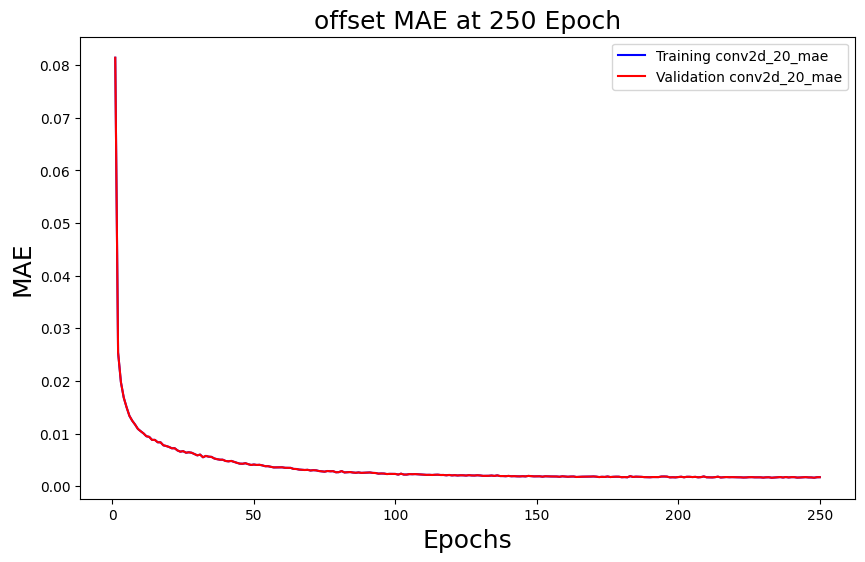

In [ ]:
plot_metric(history, 'activation_11_mae', 'val_activation_11_mae', r'$\tau_1$ MAE at 250 Epoch', 'MAE')
plot_metric(history, 'activation_14_mae', 'val_activation_14_mae', r'$\tau_2$ MAE at 250 Epoch', 'MAE')
plot_metric(history, 'activation_17_mae', 'val_activation_17_mae', r'$A_1$ MAE at 250 Epoch', 'MAE')
plot_metric(history, 'activation_20_mae', 'val_activation_20_mae', r'$A_2$  MAE at 250 Epoch', 'MAE')
plot_metric(history, 'conv2d_20_mae', 'conv2d_20_mae', 'offset MAE at 250 Epoch', 'MAE')
#plot_metric(history, 'activation_23_mae', 'val_activation_23_mae', 'offset MAE at 250 Epoch', 'MAE')

In [ ]:
fN = 'newest_model'

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Post-training: load "best" trained weights (obtained through patience - lowest value of loss)
# THIS CAN BE ANY WEIGHT FILE, AS LONG AS THE NETWORK ARCHITECTURE MATCHES THE ONE USED!
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

modelD.load_weights(fN+'.h5')

In [ ]:
import tensorflow as tf

In [ ]:
model = load_model('/content/drive/MyDrive/moved to drive/wawa_now.keras')

In [ ]:
# Upload test data and use 3D-CNN for inference

t_data = '/content/drive/MyDrive/gpt1'  # Directory with test data
stacks = os.listdir(t_data)
numS = len(stacks)

numS
nTG = 256  # Number of time-points
xX = 32
yY = 32

tpsfT = np.ndarray((numS, nTG, xX, yY, 1), dtype=np.float32)
t1T = np.ndarray((numS, xX, yY, 1), dtype=np.float32)
t2T = np.ndarray((numS, xX, yY, 1), dtype=np.float32)
a1T = np.ndarray((numS, xX, yY, 1), dtype=np.float32)
a2T = np.ndarray((numS, xX, yY, 1), dtype=np.float32)
offsetT = np.ndarray((numS, xX, yY, 1), dtype=np.float32)

# Load data
i = 0

for d in stacks:
    # Load NPZ file
    data = np.load(os.path.join(t_data, d))

    # Transpose the data to match the expected shape and Save values to respective arrays
    tpsfT[i, :, :, :, 0] = np.transpose(data['sigD'], (2, 0, 1))
    t1T[i, :, :, 0] = data['t1']
    t2T[i, :, :, 0] = data['t2']
    a1T[i, :, :, 0] = data['a1']
    a2T[i, :, :, 0] = data['a2']
    offsetT[i, :, :, 0] = data['offset']
    i += 1


# Adjust the axis if needed
tpsfT = np.moveaxis(tpsfT, 1, -2)

In [ ]:
numS

5

In [ ]:
tpsfT.shape

(5, 32, 32, 256, 1)

In [ ]:
# Perform inference on test data with trained model
testV = model.predict(tpsfT)
t1P = testV[0] # Predicted t1 values
t2P = testV[1] # Predicted t2 values
a1P = testV[2] # Predicted AR values
a2P = testV[3] # Predicted AR values
offsetP = testV[4] # Predicted AR values

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
#testV

In [ ]:
n = 1

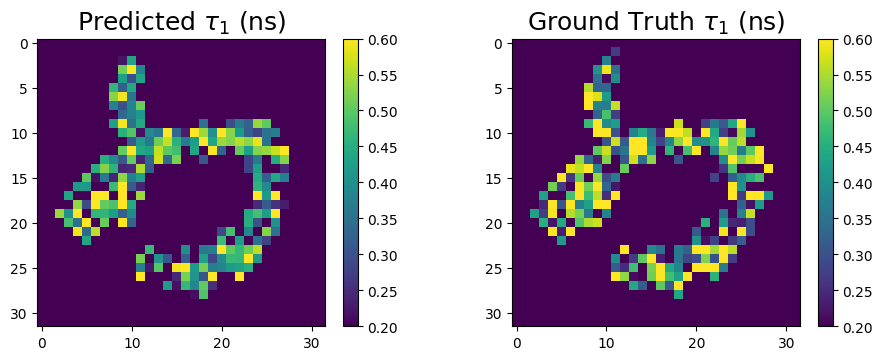

In [ ]:
# 100
#
fig = plt.figure(figsize=(10,10))

# Predicted tau1
ax1 = fig.add_subplot(3,2,1)
im1 = ax1.imshow(t1P[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=.2, vmax=.6)
ax1.set_title(r'Predicted $\tau_1$ (ns)', fontsize = 18)
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# G.T. tau1
ax2 = fig.add_subplot(3,2,2)
im2 = ax2.imshow(t1T[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=.2, vmax=.6)
ax2.set_title(r'Ground Truth $\tau_1$ (ns)', fontsize = 18)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)



plt.tight_layout()
plt.show()


In [ ]:
# Compute SSIM for the specific pair of images
ssim_score = compare_ssim(t1P[n, :, :, 0], t1T[n, :, :, 0], data_range=t1P[n, :, :, 0].max() - t1P[n, :, :, 0].min())

print(f"SSIM for the image at index {n}: {ssim_score}")



SSIM for the image at index 1: 0.8922011994222212


Tau2

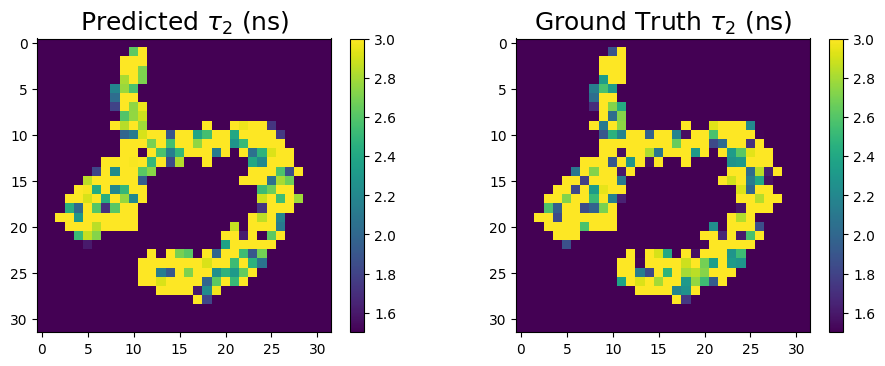

In [ ]:

fig = plt.figure(figsize=(10,10))
# Predicted tau2
ax3 = fig.add_subplot(3,2,3)
im3 = ax3.imshow(t2P[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=1.5, vmax=3)
ax3.set_title(r'Predicted $\tau_2$ (ns)', fontsize = 18)
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)


# G.T. tau2
ax4 = fig.add_subplot(3,2,4)
im4 = ax4.imshow(t2T[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=1.5, vmax=3)
ax4.set_title(r'Ground Truth $\tau_2$ (ns)', fontsize = 18)
fig.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)


plt.tight_layout()
plt.show()





In [ ]:
# Compute SSIM for the specific pair of images
ssim_score = compare_ssim(t2P[n, :, :, 0], t2T[n, :, :, 0], data_range=t2P[n, :, :, 0].max() - t2P[n, :, :, 0].min())

print(f"SSIM for the image at index {n}: {ssim_score}")


SSIM for the image at index 1: 0.1694712517727938


In [ ]:
offsetP.shape

(2, 32, 32, 1)

In [ ]:
offsetP[n,:,:,0] = np.maximum(offsetP[n,:,:,0], 0)

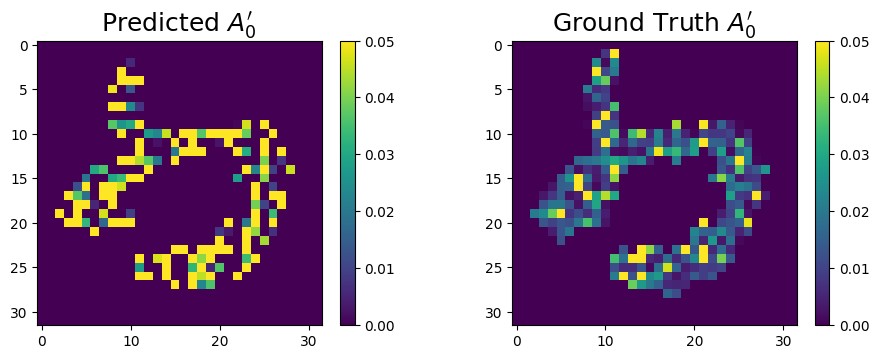

In [ ]:

fig = plt.figure(figsize=(10,10))

# Predicted AR
ax5 = fig.add_subplot(3,2,5)
im5 = ax5.imshow(offsetP[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=0, vmax=0.05)
ax5.set_title("Predicted $A_0'$ ", fontsize = 18)
fig.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04)
# G.T. tau1
ax6 = fig.add_subplot(3,2,6)
im6 = ax6.imshow(offsetT[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=0, vmax=0.05)
ax6.set_title("Ground Truth $A_0'$", fontsize = 18)
fig.colorbar(im6, ax=ax6, fraction=0.046, pad=0.04)



plt.tight_layout()
plt.show()

In [ ]:
n = 1

In [ ]:

# Compute SSIM for the specific pair of images
ssim_score = compare_ssim(offsetP[n, :, :, 0], offsetT[n, :, :, 0], data_range=offsetP[n, :, :, 0].max() - offsetP[n, :, :, 0].min())

print(f"SSIM for the image at index {n}: {ssim_score}")

SSIM for the image at index 1: 0.2606265362627543


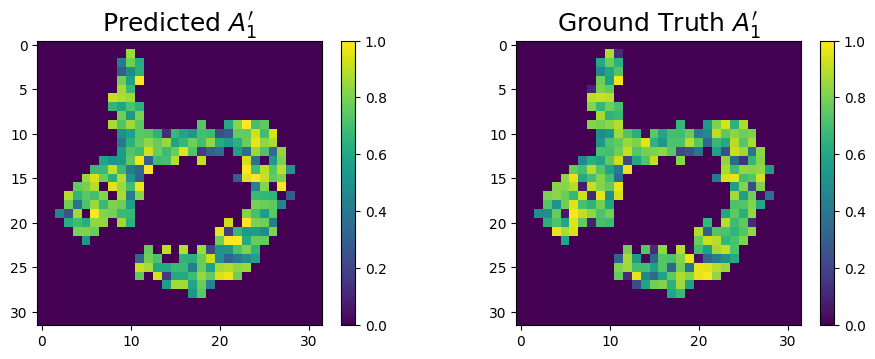

In [ ]:

fig = plt.figure(figsize=(10,10))

# Predicted AR
ax5 = fig.add_subplot(3,2,5)
im5 = ax5.imshow(a1P[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
ax5.set_title(r"Predicted $A_1'$", fontsize = 18)
fig.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04)
# G.T. tau1
ax6 = fig.add_subplot(3,2,6)
im6 = ax6.imshow(a1T[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
ax6.set_title(r"Ground Truth $A_1'$", fontsize = 18)
fig.colorbar(im6, ax=ax6, fraction=0.046, pad=0.04)



plt.tight_layout()
plt.show()

In [ ]:

# Compute SSIM for the specific pair of images
ssim_score = compare_ssim(a1P[n, :, :, 0], a1T[n, :, :, 0], data_range=a1T[n, :, :, 0].max() - a1T[n, :, :, 0].min())

print(f"SSIM for the image at index {n}: {ssim_score}")

SSIM for the image at index 1: 0.13474645059570925


In [ ]:

# Compute SSIM for the specific pair of images
ssim_score = compare_ssim(a2P[n, :, :, 0], a2T[n, :, :, 0], data_range=a2T[n, :, :, 0].max() - a2T[n, :, :, 0].min())

print(f"SSIM for the image at index {n}: {ssim_score}")

SSIM for the image at index 0: 0.9920017013006662


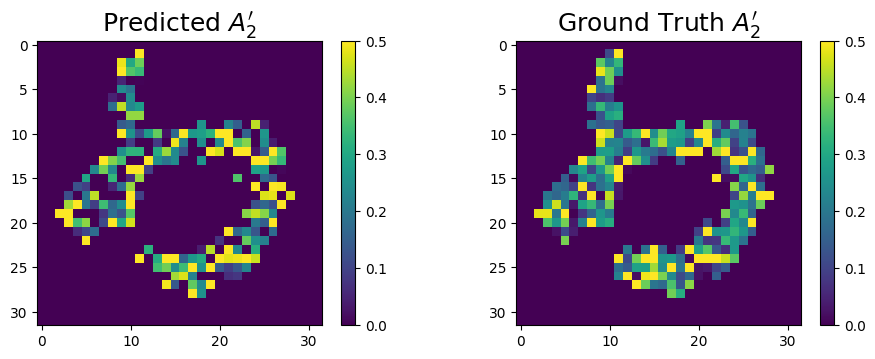

In [ ]:

fig = plt.figure(figsize=(10,10))

# Predicted AR
ax5 = fig.add_subplot(3,2,5)
im5 = ax5.imshow(a2P[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=0, vmax=0.5)
ax5.set_title("Predicted $A_2'$", fontsize = 18)
fig.colorbar(im5, ax=ax5, fraction=0.046, pad=0.04)
# G.T. tau1
ax6 = fig.add_subplot(3,2,6)
im6 = ax6.imshow(a2T[n,:,:,0], cmap='viridis', interpolation='nearest', vmin=0, vmax=0.5)
ax6.set_title("Ground Truth $A_2'$", fontsize = 18)
fig.colorbar(im6, ax=ax6, fraction=0.046, pad=0.04)



plt.tight_layout()
plt.show()

In [ ]:

# Compute SSIM for the specific pair of images
ssim_score = compare_ssim(a2P[n, :, :, 0], a2T[n, :, :, 0], data_range=a2T[n, :, :, 0].max() - a2T[n, :, :, 0].min())

print(f"SSIM for the image at index {n}: {ssim_score}")

SSIM for the image at index 0: 0.9880378143145487


In [ ]:
offsetT[n, :, :, 0].max()

0.04999671